In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
concatenated_dataset = pd.read_csv("D:/IIT/2 nd Year/2nd Sem/Data Engineering/Course Work/HCHO_Prediction/preprocessed dataset/concatenated_dataset.csv")
concatenated_dataset

,HCHO Reading,Location,Current Date,Next Date
0,0.000263,"Deniyaya, Matara",2019-01-01,2019-01-02
1,0.000263,Nuwara Eliya Proper,2019-01-01,2019-01-02
2,0.000263,Colombo Proper,2019-01-02,2019-01-03
3,0.000006,"Deniyaya, Matara",2019-01-02,2019-01-03
4,0.000006,Nuwara Eliya Proper,2019-01-02,2019-01-03
...,...,...,...,...
12774,0.000158,Kurunegala Proper,2023-12-30,2023-12-31
12775,0.000117,Jaffna Proper,2023-12-30,2023-12-31
12776,0.000117,"Bibile, Monaragala",2023-12-31,2024-01-01
12777,0.000065,Kurunegala Proper,2023-12-31,2024-01-01


In [3]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
adf_test = adfuller(concatenated_dataset['HCHO Reading'])

print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

# Based on the p-value, decide on stationarity
if adf_test[1] > 0.05:
    print("The series is likely non-stationary and may need differencing.")
else:
    print("The series is likely stationary.")

ADF Statistic: -11.904442
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
The series is likely stationary.


In [4]:
# Convert 'Current Date' to datetime and set as index
concatenated_dataset['Current Date'] = pd.to_datetime(concatenated_dataset['Current Date'])
concatenated_dataset.set_index('Current Date', inplace=True)

# Output the first few rows and the index to verify changes
df_head_after = concatenated_dataset.head()
df_index_info = concatenated_dataset.index

df_head_after, df_index_info

(              HCHO Reading             Location   Next Date
 Current Date                                               
 2019-01-01        0.000263     Deniyaya, Matara  2019-01-02
 2019-01-01        0.000263  Nuwara Eliya Proper  2019-01-02
 2019-01-02        0.000263       Colombo Proper  2019-01-03
 2019-01-02        0.000006     Deniyaya, Matara  2019-01-03
 2019-01-02        0.000006  Nuwara Eliya Proper  2019-01-03,
 DatetimeIndex(['2019-01-01', '2019-01-01', '2019-01-02', '2019-01-02',
                '2019-01-02', '2019-01-03', '2019-01-03', '2019-01-03',
                '2019-01-04', '2019-01-04',
                ...
                '2023-12-28', '2023-12-29', '2023-12-29', '2023-12-29',
                '2023-12-30', '2023-12-30', '2023-12-30', '2023-12-31',
                '2023-12-31', '2023-12-31'],
               dtype='datetime64[ns]', name='Current Date', length=12779, freq=None))

# Bibile, Monaragala

In [5]:
# Selecting the data for the model
monaragala_data = concatenated_dataset[concatenated_dataset['Location'] == 'Bibile, Monaragala']
monaragala_data

,HCHO Reading,Location,Next Date
Current Date,,,
2019-01-02,1.919915e-05,"Bibile, Monaragala",2019-01-03
2019-01-03,2.811448e-05,"Bibile, Monaragala",2019-01-04
2019-01-04,3.747998e-05,"Bibile, Monaragala",2019-01-05
2019-01-05,-1.798261e-05,"Bibile, Monaragala",2019-01-06
2019-01-06,1.457837e-04,"Bibile, Monaragala",2019-01-07
...,...,...,...
2023-12-27,-7.696313e-08,"Bibile, Monaragala",2023-12-28
2023-12-28,7.547085e-05,"Bibile, Monaragala",2023-12-29
2023-12-29,5.139770e-05,"Bibile, Monaragala",2023-12-30


In [6]:
split_ratio = 0.8
train_size = int(len(monaragala_data) * split_ratio)
train_data, test_data = monaragala_data[0:train_size], monaragala_data[train_size:]
monaragala_df_shape = train_data.shape
monaragala_df_shape

(1460, 3)

In [7]:
# Define and fit the S-ARIMA model on training data
model = SARIMAX(monaragala_data["HCHO Reading"][0:1401], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()

# Forecast for test data
forecast = model_fit.forecast(steps=len(test_data))

# Calculate evaluation metrics on test data
rmse = mean_squared_error(test_data["HCHO Reading"], forecast, squared=False)  # Root Mean Squared Error
mse = mean_squared_error(test_data["HCHO Reading"], forecast)  # Mean Squared Error
#mape = mean_absolute_percentage_error(test_data["HCHO reading"], forecast) * 100  # Mean Absolute Percentage Error

# Print the evaluation metrics
print("RMSE:", rmse)
print("MSE:", mse)
#print("MAPE:", mape)

RMSE: 0.00024764428887041
MSE: 6.132769381013107e-08


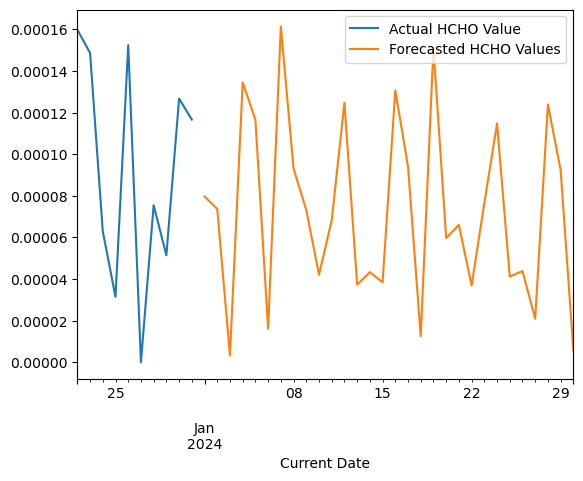

In [8]:
sarima_model = SARIMAX(monaragala_data["HCHO Reading"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Adjusting optimization parameters
sarima_result = sarima_model.fit()
# Generating forecast
forecast = sarima_result.forecast(steps=30)
monaragala_data["HCHO Reading"][-10:].plot(label="Actual HCHO Value")
forecast.plot(label="Forecasted HCHO Values")
plt.legend()


# Colombo

In [9]:
# Selecting the data for the model
colombo_data = concatenated_dataset[concatenated_dataset['Location'] == 'Colombo Proper']
colombo_data

,HCHO Reading,Location,Next Date
Current Date,,,
2019-01-02,0.000263,Colombo Proper,2019-01-03
2019-01-03,0.000099,Colombo Proper,2019-01-04
2019-01-04,0.000210,Colombo Proper,2019-01-05
2019-01-05,0.000179,Colombo Proper,2019-01-06
2019-01-06,0.000108,Colombo Proper,2019-01-07
...,...,...,...
2023-12-28,0.000228,Colombo Proper,2023-12-29
2023-12-29,0.000140,Colombo Proper,2023-12-30
2023-12-30,0.000140,Colombo Proper,2023-12-31


In [10]:
split_ratio = 0.8
train_size = int(len(colombo_data) * split_ratio)
train_data, test_data = colombo_data[0:train_size], colombo_data[train_size:]
colombo_df_shape = train_data.shape
colombo_df_shape

(1460, 3)

In [11]:
# Define and fit the S-ARIMA model on training data
model = SARIMAX(colombo_data["HCHO Reading"][0:1401], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()

# Forecast for test data
forecast = model_fit.forecast(steps=len(test_data))

# Calculate evaluation metrics on test data
rmse = mean_squared_error(test_data["HCHO Reading"], forecast, squared=False)  # Root Mean Squared Error
mse = mean_squared_error(test_data["HCHO Reading"], forecast)  # Mean Squared Error
#mape = mean_absolute_percentage_error(test_data["HCHO reading"], forecast) * 100  # Mean Absolute Percentage Error

# Print the evaluation metrics
print("RMSE:", rmse)
print("MSE:", mse)
#print("MAPE:", mape)

RMSE: 0.0009819864971461986
MSE: 9.64297480577461e-07


In [12]:
colombo_data.tail()

,HCHO Reading,Location,Next Date
Current Date,,,
2023-12-28,0.000228,Colombo Proper,2023-12-29
2023-12-29,0.000140,Colombo Proper,2023-12-30
2023-12-30,0.000140,Colombo Proper,2023-12-31
2023-12-31,0.000080,Colombo Proper,2024-01-01
2022-03-07,0.000254,Colombo Proper,2022-03-08


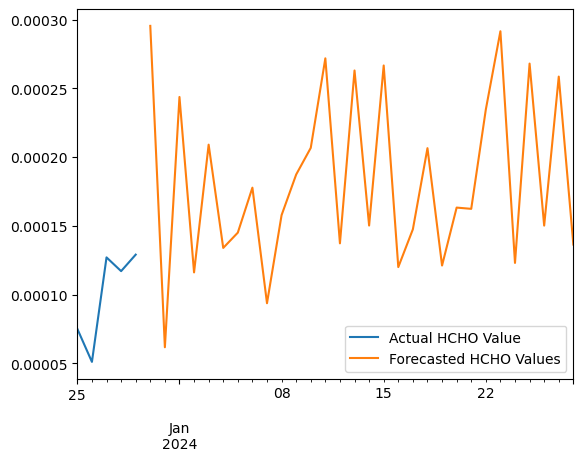

In [13]:
sarima_model = SARIMAX(colombo_data["HCHO Reading"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Adjusting optimization parameters
sarima_result = sarima_model.fit()
# Generating forecast
forecast = sarima_result.forecast(steps=30)

last_index = colombo_data.index[-4]
new_index = pd.date_range(start=last_index, periods=31, freq='D')[1:]

# Generating forecast
forecast = sarima_result.forecast(steps=30, index=new_index)

colombo_data = pd.DataFrame({'HCHO Reading': [0.000075, 0.000051, 0.000127, 0.000117, 0.000129]},
                      index=pd.date_range('2023-12-25', periods=5, freq='D'))

colombo_data["HCHO Reading"][-10:].plot(label="Actual HCHO Value")
forecast.plot(label="Forecasted HCHO Values")
plt.legend()

# Deniyaya, Matara

In [14]:
# Selecting the data for the model
matara_data = concatenated_dataset[concatenated_dataset['Location'] == 'Deniyaya, Matara']
matara_data

,HCHO Reading,Location,Next Date
Current Date,,,
2019-01-01,0.000263,"Deniyaya, Matara",2019-01-02
2019-01-02,0.000006,"Deniyaya, Matara",2019-01-03
2019-01-03,0.000236,"Deniyaya, Matara",2019-01-04
2019-01-04,0.000064,"Deniyaya, Matara",2019-01-05
2019-01-05,0.000053,"Deniyaya, Matara",2019-01-06
...,...,...,...
2023-12-28,0.000228,"Deniyaya, Matara",2023-12-29
2023-12-29,0.000140,"Deniyaya, Matara",2023-12-30
2023-12-30,0.000116,"Deniyaya, Matara",2023-12-31


In [15]:
split_ratio = 0.8
train_size = int(len(matara_data) * split_ratio)
train_data, test_data = matara_data[0:train_size], matara_data[train_size:]
matara_df_shape = train_data.shape
matara_df_shape

(1460, 3)

In [16]:
# Define and fit the S-ARIMA model on training data
model = SARIMAX(matara_data["HCHO Reading"][0:1401], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()

# Forecast for test data
forecast = model_fit.forecast(steps=len(test_data))

# Calculate evaluation metrics on test data
rmse = mean_squared_error(test_data["HCHO Reading"], forecast, squared=False)  # Root Mean Squared Error
mse = mean_squared_error(test_data["HCHO Reading"], forecast)  # Mean Squared Error
#mape = mean_absolute_percentage_error(test_data["HCHO reading"], forecast) * 100  # Mean Absolute Percentage Error

# Print the evaluation metrics
print("RMSE:", rmse)
print("MSE:", mse)
#print("MAPE:", mape)

RMSE: 0.00022619141563682248
MSE: 5.1162556507789784e-08


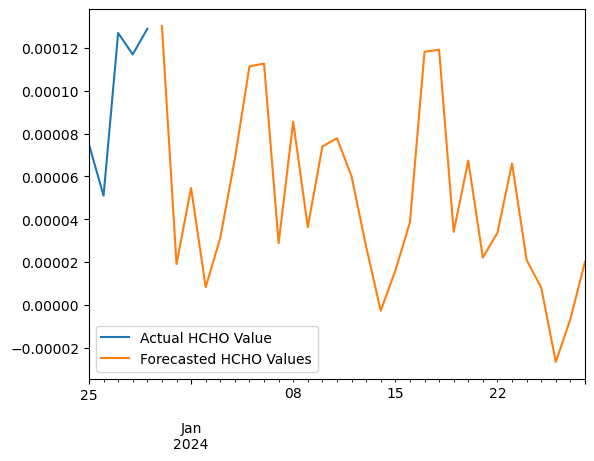

In [17]:
sarima_model = SARIMAX(matara_data["HCHO Reading"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Adjusting optimization parameters
sarima_result = sarima_model.fit()
# Generating forecast
forecast = sarima_result.forecast(steps=30)

last_index = matara_data.index[-4]
new_index = pd.date_range(start=last_index, periods=31, freq='D')[1:]

# Generating forecast
forecast = sarima_result.forecast(steps=30, index=new_index)

matara_data = pd.DataFrame({'HCHO Reading': [0.000075, 0.000051, 0.000127, 0.000117, 0.000129]},
                      index=pd.date_range('2023-12-25', periods=5, freq='D'))

matara_data["HCHO Reading"][-10:].plot(label="Actual HCHO Value")
forecast.plot(label="Forecasted HCHO Values")
plt.legend()

# Jaffna

In [18]:
# Selecting the data for the model
jaffna_data = concatenated_dataset[concatenated_dataset['Location'] == 'Jaffna Proper']
jaffna_data

,HCHO Reading,Location,Next Date
Current Date,,,
2019-01-01,0.000058,Jaffna Proper,2019-01-02
2019-01-02,0.000102,Jaffna Proper,2019-01-03
2019-01-03,0.000039,Jaffna Proper,2019-01-04
2019-01-04,-0.000002,Jaffna Proper,2019-01-05
2019-01-05,0.000159,Jaffna Proper,2019-01-06
...,...,...,...
2023-12-27,0.000075,Jaffna Proper,2023-12-28
2023-12-28,0.000051,Jaffna Proper,2023-12-29
2023-12-29,0.000127,Jaffna Proper,2023-12-30


In [19]:
split_ratio = 0.8
train_size = int(len(jaffna_data) * split_ratio)
train_data, test_data = jaffna_data[0:train_size], jaffna_data[train_size:]
jaffna_df_shape = train_data.shape
jaffna_df_shape

(1460, 3)

In [20]:
# Define and fit the S-ARIMA model on training data
model = SARIMAX(jaffna_data["HCHO Reading"][0:1401], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()

# Forecast for test data
forecast = model_fit.forecast(steps=len(test_data))

# Calculate evaluation metrics on test data
rmse = mean_squared_error(test_data["HCHO Reading"], forecast, squared=False)  # Root Mean Squared Error
mse = mean_squared_error(test_data["HCHO Reading"], forecast)  # Mean Squared Error
#mape = mean_absolute_percentage_error(test_data["HCHO reading"], forecast) * 100  # Mean Absolute Percentage Error

# Print the evaluation metrics
print("RMSE:", rmse)
print("MSE:", mse)
#print("MAPE:", mape)

RMSE: 0.00013281272138471209
MSE: 1.763921896161316e-08


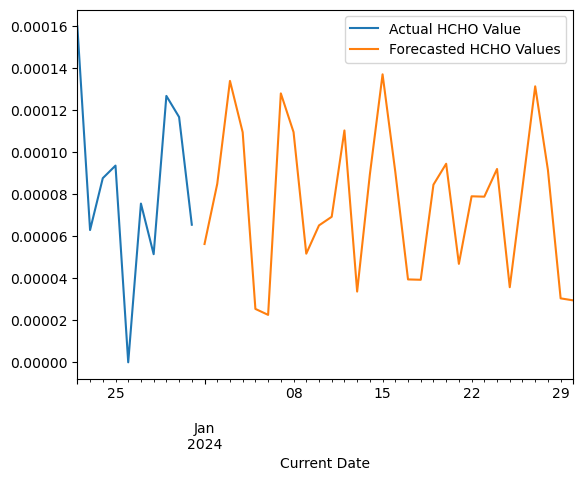

In [21]:
sarima_model = SARIMAX(jaffna_data["HCHO Reading"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Adjusting optimization parameters
sarima_result = sarima_model.fit()
# Generating forecast
forecast = sarima_result.forecast(steps=30)
jaffna_data["HCHO Reading"][-10:].plot(label="Actual HCHO Value")
forecast.plot(label="Forecasted HCHO Values")
plt.legend()

# Kandy

In [22]:
# Selecting the data for the model
kandy_data = concatenated_dataset[concatenated_dataset['Location'] == 'Kandy Proper']
kandy_data

,HCHO Reading,Location,Next Date
Current Date,,,
2019-01-02,0.000092,Kandy Proper,2019-01-03
2019-01-03,0.000092,Kandy Proper,2019-01-04
2019-01-04,0.000191,Kandy Proper,2019-01-05
2019-01-05,0.000122,Kandy Proper,2019-01-06
2019-01-06,-0.000065,Kandy Proper,2019-01-07
...,...,...,...
2023-12-27,0.000056,Kandy Proper,2023-12-28
2023-12-28,0.000056,Kandy Proper,2023-12-29
2023-12-29,0.000056,Kandy Proper,2023-12-30


In [23]:
split_ratio = 0.8
train_size = int(len(kandy_data) * split_ratio)
train_data, test_data = kandy_data[0:train_size], kandy_data[train_size:]
kandy_df_shape = train_data.shape
kandy_df_shape

(1460, 3)

In [24]:
# Define and fit the S-ARIMA model on training data
model = SARIMAX(kandy_data["HCHO Reading"][0:1401], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()

# Forecast for test data
forecast = model_fit.forecast(steps=len(test_data))

# Calculate evaluation metrics on test data
rmse = mean_squared_error(test_data["HCHO Reading"], forecast, squared=False)  # Root Mean Squared Error
mse = mean_squared_error(test_data["HCHO Reading"], forecast)  # Mean Squared Error
#mape = mean_absolute_percentage_error(test_data["HCHO reading"], forecast) * 100  # Mean Absolute Percentage Error

# Print the evaluation metrics
print("RMSE:", rmse)
print("MSE:", mse)
#print("MAPE:", mape)

RMSE: 0.0011756780753855685
MSE: 1.3822189369423144e-06


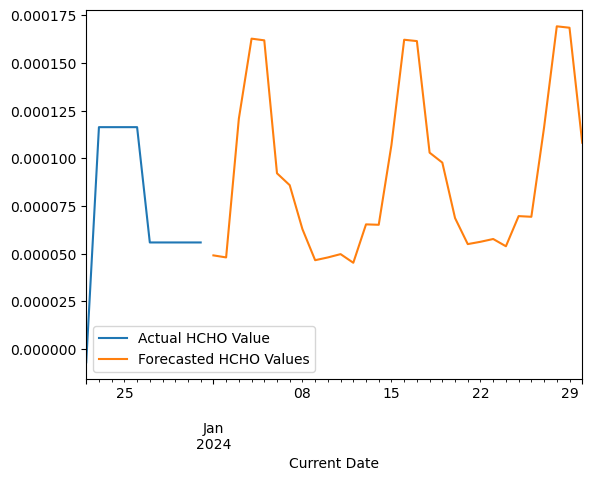

In [25]:
sarima_model = SARIMAX(kandy_data["HCHO Reading"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Adjusting optimization parameters
sarima_result = sarima_model.fit()
# Generating forecast
forecast = sarima_result.forecast(steps=30)
kandy_data["HCHO Reading"][-10:].plot(label="Actual HCHO Value")
forecast.plot(label="Forecasted HCHO Values")
plt.legend()

# Kurunegala

In [26]:
# Selecting the data for the model
kurunegala_data = concatenated_dataset[concatenated_dataset['Location'] == 'Kurunegala Proper']
kurunegala_data

,HCHO Reading,Location,Next Date
Current Date,,,
2019-01-01,0.000088,Kurunegala Proper,2019-01-02
2019-01-02,0.000137,Kurunegala Proper,2019-01-03
2019-01-03,0.000148,Kurunegala Proper,2019-01-04
2019-01-04,-0.000002,Kurunegala Proper,2019-01-05
2019-01-05,0.000249,Kurunegala Proper,2019-01-06
...,...,...,...
2023-12-27,0.000075,Kurunegala Proper,2023-12-28
2023-12-28,0.000051,Kurunegala Proper,2023-12-29
2023-12-29,0.000127,Kurunegala Proper,2023-12-30


In [27]:
split_ratio = 0.8
train_size = int(len(kurunegala_data) * split_ratio)
train_data, test_data = kurunegala_data[0:train_size], kurunegala_data[train_size:]
kurunegala_df_shape = train_data.shape
kurunegala_df_shape

(1460, 3)

In [28]:
# Define and fit the S-ARIMA model on training data
model = SARIMAX(kurunegala_data["HCHO Reading"][0:1401], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()

# Forecast for test data
forecast = model_fit.forecast(steps=len(test_data))

# Calculate evaluation metrics on test data
rmse = mean_squared_error(test_data["HCHO Reading"], forecast, squared=False)  # Root Mean Squared Error
mse = mean_squared_error(test_data["HCHO Reading"], forecast)  # Mean Squared Error
#mape = mean_absolute_percentage_error(test_data["HCHO reading"], forecast) * 100  # Mean Absolute Percentage Error

# Print the evaluation metrics
print("RMSE:", rmse)
print("MSE:", mse)
#print("MAPE:", mape)

RMSE: 0.0003599757235931967
MSE: 1.2958252157644556e-07


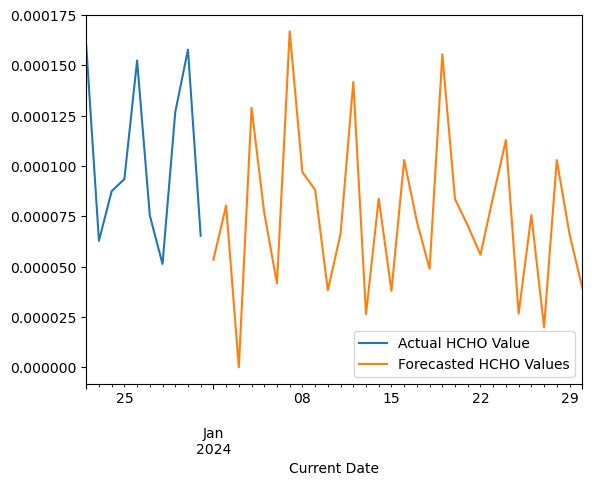

In [29]:
sarima_model = SARIMAX(kurunegala_data["HCHO Reading"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Adjusting optimization parameters
sarima_result = sarima_model.fit()
# Generating forecast
forecast = sarima_result.forecast(steps=30)
kurunegala_data["HCHO Reading"][-10:].plot(label="Actual HCHO Value")
forecast.plot(label="Forecasted HCHO Values")
plt.legend()

# Nuwara Eliya

In [30]:
# Selecting the data for the model
nuwara_eliya_data = concatenated_dataset[concatenated_dataset['Location'] == 'Nuwara Eliya Proper']
nuwara_eliya_data

,HCHO Reading,Location,Next Date
Current Date,,,
2019-01-01,0.000263,Nuwara Eliya Proper,2019-01-02
2019-01-02,0.000006,Nuwara Eliya Proper,2019-01-03
2019-01-03,0.000191,Nuwara Eliya Proper,2019-01-04
2019-01-04,0.000051,Nuwara Eliya Proper,2019-01-05
2019-01-05,0.000065,Nuwara Eliya Proper,2019-01-06
...,...,...,...
2023-12-27,0.000228,Nuwara Eliya Proper,2023-12-28
2023-12-28,0.000228,Nuwara Eliya Proper,2023-12-29
2023-12-29,0.000140,Nuwara Eliya Proper,2023-12-30


In [31]:
split_ratio = 0.8
train_size = int(len(nuwara_eliya_data) * split_ratio)
train_data, test_data = nuwara_eliya_data[0:train_size], nuwara_eliya_data[train_size:]
nuwara_eliya_df_shape = train_data.shape
nuwara_eliya_df_shape

(1460, 3)

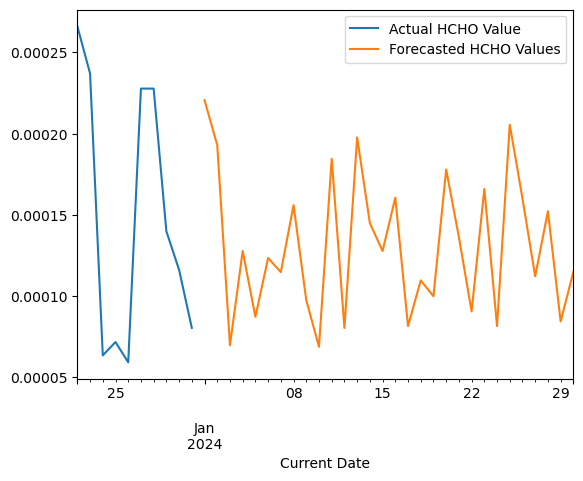

In [32]:
sarima_model = SARIMAX(nuwara_eliya_data["HCHO Reading"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Adjusting optimization parameters
sarima_result = sarima_model.fit()
# Generating forecast
forecast = sarima_result.forecast(steps=30)
nuwara_eliya_data["HCHO Reading"][-10:].plot(label="Actual HCHO Value")
forecast.plot(label="Forecasted HCHO Values")
plt.legend()